<a href="https://colab.research.google.com/github/SoumyaShreeram/Microlensing_with_NeuralNets/blob/master/06_Testing_NNs_with_Season_Gaps_and_Interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Testing Neural Network Architecture

The following notebook tests NNs using the light-curves that are
  - Linearly intrapolated
  - use Gaussian process intropolation

The model is trained, tested, and evaluated. 

Author: Soumya Shreeram <br>
Script adapted from: Millon Martin & Kevin Müller <br>
Date: 23rd February 2020

Import all required python libraries

In [0]:
from google.colab import drive
import os
import pickle
import importlib
import itertools

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import random
import os
from IPython.display import Image, SVG

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from scipy.interpolate import interp1d 

%tensorflow_version 1.x
import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Activation, InputSpec
from tensorflow.python.keras.layers import Conv1D, Conv2D
from tensorflow.python.keras.layers import MaxPooling1D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Add, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

Mount google drive

In [22]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Directory where the `python` files are stored on Google Drive. These imported files are also available in `.ipynb` format on the GitHub repo with same names (without the dr; <strike>`dr`</strike>`0X_sameFileName`). dr stands for drive. 

In [0]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks')

import nb_02i_preprocessing_data as dat
import nb_03_neural_network_designs as nnet

Setting up the path to the data directory

In [0]:
current_dir = os.getcwd()
data_dir = '/content/gdrive/My Drive/training_set_microlensing/'
save_image_dir = r'/content/gdrive/My Drive/Colab Notebooks/Images/'
save_model_dir = r'/content/gdrive/My Drive/Colab Notebooks/Models/'

### 1. Input parameters

In [0]:
v_t = [500, 300] # transverse velcity
v_t_idx = 0 # choose index value for the velocity you would like (0 or 1)
r_0 = (2,4,10,15,20,30,40,60,80,100) # scale radius
output_class_names = [str(r) for r in r_0 ]

# select type of Interpolation
cubic, linear = False, True

""""select the type of nnet's to use
old_version :: borrowed from Martin & Kevins code
modified_version :: some minor changes compared to previous version
"""
old_version, modified_version = True, False

# data loaded with season gaps
season_gaps = True

# if using the new data set generated by Eric
new_data_set = True

### 2. Load the data

There are 10 categories into which the light-curves are classified. Each category is represented by the scale radius `r_0`. For every scale radius, there exists a light-curve whose data points are stored in the 3D array `l_curves`.

In [16]:
# sets the sampling parameters
sample_params = dat.setSamplingParameters(v_t[v_t_idx], data_dir, season_gaps)

# initializes data arrays
class_cat, l_curves, out_catergories, out_radii = dat.initializer(r_0, \
                                                                  sample_params)

for idx, rad in enumerate(r_0):
  filename = dat.getFilename(data_dir, idx, rad, v_t[v_t_idx], sample_params, \
                             season_gaps, new_data_set)
  
  # load data from the file
  l_curves, mjhd,_ = dat.loadData(filename, idx, l_curves, sample_params, idx,\
                                  season_gaps, new_data_set)
  out_catergories[idx*sample_params[0][idx]:(idx+1)*sample_params[0][idx]] = class_cat[1][idx]
  out_radii[idx*sample_params[0][idx]:(idx+1)*sample_params[0][idx]] = r_0[idx]

print('Shape of light curves vector:', np.shape(l_curves))

Shape of light curves vector: (50000, 955, 1)


#### 2.1 Interpolation of the light curves

In [0]:
def interpolateLCurves(l_curves, mjhd, l_curves_interpolated, type_inter='linear'):
  """
  Function for interpolating the light curves 'linearly'
  @l_curves :: non-interpolated light curves 3Darray
  @l_curves_interpolated :: empty array with shape same as l_curves

  @Returns:: linearly interpolated light curves 3Darray
  """
  for i in range(len(l_curves)):
    # x array of times
    x = mjhd
    y = l_curves[i, :, 0]
    
    # interpolation
    f = interp1d(x,y, kind=type_inter)
    
    # capturing the features using y_inter
    xnew = np.linspace(x[0], x[-1], num=len(mjhd))
    y_inter = f(xnew)

    # setting the shape same as that on l_curves array
    y_inter.shape = (len(y_inter), 1)
    l_curves_interpolated = np.append(l_curves_interpolated, [y_inter], axis=0)
  return l_curves_interpolated, xnew

In [0]:
l_curves_interpolated = np.array([])
l_curves_interpolated.shape = (0, len(l_curves[0,:,0]),1)
mjhd = np.load(data_dir+'mjhd.npy')

# linear/cubic interpolated the light curves
if linear:
  lc_inter_linear, mjhd_inter = interpolateLCurves(l_curves, mjhd, l_curves_interpolated, \
                                       type_inter='linear')
  
if cubic:
  lc_inter_cubic, mjhd_inter = interpolateLCurves(l_curves, mjhd, l_curves_interpolated, \
                                      type_inter='cubic')

Saves the light curve arrays

In [9]:
print("shape of light curves arrays:", np.shape(l_curves))
dat.saveFile(data_dir, 'Light_Curves/lightcurves_SeasonGaps_NoInterpolation', l_curves)

shape of light curves arrays: (50000, 955, 1)
File saved


#### 2.1 Plots of some random light-curves

4.0 2.0


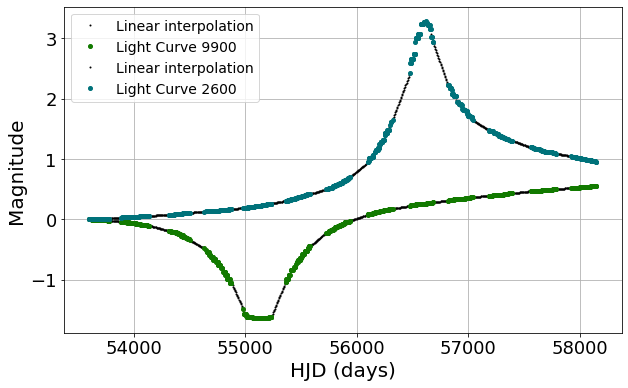

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
n = [9900, 2600]
colors = ['#127a00',  '#00727a', '#888894']

for i, num in enumerate(n):
  # light curves with cubic interpolation
  if cubic:
    ax.plot(mjhd_inter, lc_inter_cubic[n[i], :, 0], '.', color='r', label='Cubic interpolation', markersize=4)

  # light curves with linear interpolation
  ax.plot(mjhd_inter, lc_inter_linear[n[i], :, 0], '.', color='k', label='Linear interpolation', markersize=2)

  # without interpolation
  ax.plot(mjhd, l_curves[n[i], :], '.', color=colors[i], label='Light Curve %i'%(n[i]), markersize=8)

dat.setLabels(ax, 'HJD (days)', 'Magnitude', ticks=True, legend=True)
fig.savefig(save_image_dir+'/interpolated_lcurves.png') 

print(out_radii[9900], out_radii[2600])

### 3. Generate training and testing data sets

Proceeding with linear interpolation.

In [0]:
train_l_curves, test_l_curves, onehot_train, \
onehot_test = dat.generateTestTrain(lc_inter_linear, out_catergories, out_radii, r_0)

trainX, trainy, testX, testy = train_l_curves, onehot_train, test_l_curves, onehot_test

### 4. Compiling the 3 networks

The three networks compiled here are coded in `04_Neural_Network_Designs.ipynb` that have been saved as `dr04_Neural_Network_Designs.py`, for ease of importing it. The python files can be found in the GitHub repo folder *python files*. 

Note that if you are running this from colab, need to have these `.py` files in your drive folder *Colab Notebooks*. 

Default constants that can be modified.

In [25]:
# choose which network to use (default CNN2)
CNN1, CNN2, ResNet = False, False, True

model_types = [CNN1, CNN2, ResNet]
model_name_list = ['CNN1','CNN2','ResNet']

for i in range(len(model_name_list)):
  if model_types[i]:
    model_name = model_name_list[i]
print('Using the Neural Network:', model_name)

Using the Neural Network: ResNet


The following code block uses the methods defined in the file `dr04_Neural_Network_Designs.py`: imported as **`nnet`**

Model parameters are defined in the methods in **`nnet`** additionally some more details:
* `num_hidden_nodes`: number of nodes in hidden fully connected layer
*`dropout_ratio`: % of nodes in the hidden layer to dropout during back-propagation update of the network weights

#### 4.1 Compiling CNN2

In [0]:
if CNN2:
  # reloads the file if any changes are made
  importlib.reload(nnet)

  # CNN2 model parameters
  num_filter = (32, 32, 44, 44)
  kern_size = (21,21,15,15)
  maxpoolsize = (None, 15, None, 15)
  shortcut_link = (0,1,2,3)
  batch_norm = False
  dropout_ratio = 0.4  
  sampling = 3
  num_pieces = 1
  num_hidden_nodes = [1500]
  
  # prepare data with sample cuts with the correct shape
  testX = nnet.prepareDataSampleCuts(testX, sampling, num_pieces)
  trainX = nnet.prepareDataSampleCuts(trainX, sampling, num_pieces)

  # build the model
  inputs, outputs = nnet.buildModelCNN2(sample_params[2], num_filter, kern_size, \
                                                  maxpoolsize, num_hidden_nodes, \
                                                  dropout_ratio, shortcut_link, \
                                                  batch_norm, trainX.shape, r_0)
  
  # optimization, compilation parameters
  optimizer_type = Adam(lr=5e-4)  
  loss = 'categorical_crossentropy'  
  metrics = ['categorical_accuracy'] 

  # compiles the model
  model = nnet.compileDisplayNetwork(inputs, outputs, optimizer_type, loss, \
                                    metrics, save_image_dir+'CNN2', True)
    
  print('Network created')

#### 4.2 Compiling ResNet

In [0]:
if ResNet:
  # reloads the file if any changes are made
  importlib.reload(nnet)

  # ResNet model parameters
  num_filter = (32, 32, 32)
  kern_size = (10,20,50)
  n_block = 5
  maxpoolsize = 3
  num_hidden_nodes =[1000.0,]
  dropout_ratio = 0.7 
  batch_norm = True
  sampling = 1
  num_pieces = 1

  # build network
  inputs, outputs = nnet.defineNetworkDesignResnet(sample_params[2], num_filter, kern_size, n_block, \
                                 maxpoolsize, num_hidden_nodes, dropout_ratio, r_0,\
                                 batch_norm)
  
  # ResNet compilation parameters
  learning_rate = 1e-4
  max_epochs = 80
  decay = learning_rate/max_epochs
  optimizer_type = Adam(lr=learning_rate, decay = decay)  
  loss = 'categorical_crossentropy'  
  metrics = ['categorical_accuracy'] 

  # compiles network
  model = nnet.compileDisplayNetwork(inputs, outputs, optimizer_type, loss, \
                                     metrics,save_image_dir+'ResNet', True)
  
  #model.load_weights('/content/gdrive/My Drive/Colab_Notebooks/Deep_learning_for_optical_IMaging/Resnet_weights.h5')
  print('Network created')

### 5. Training the network

Constants used for training the network

In [0]:
validation_split_ratio = 0.2  # % of the seen dataset to be put aside for validation, rest is for training
max_epochs = 50  # maxmimum number of epochs to be iterated
batch_size = 60   # batch size for the training data set
num_inputs = 1
verbose = 1

In [28]:
if CNN1:
  model_history, accuracy = nnet.compileFitEvaluateModel(model, trainX, trainy, testX, testy, loss, optimizer, metrics,\
                                                       verbose, epochs, batch_size, validation_split)

# trains the model
model, model_history = nnet.trainModel(model, trainX, trainy, batch_size, \
                                       max_epochs, validation_split_ratio, verbose)

# evaluates and predicts the results from the trained model
results, predictions = nnet.evaluatePredictModel(model, testX, testy, verbose)
  
print('Training completed')
print('[test loss, test acc] = ', results)

Train on 32000 samples, validate on 8000 samples
Epoch 1/50
32000/32000 [==============================] - 28s 863us/sample - loss: 2.2060 - categorical_accuracy: 0.1959 - val_loss: 1.8185 - val_categorical_accuracy: 0.2652
Epoch 2/50
32000/32000 [==============================] - 27s 837us/sample - loss: 1.8030 - categorical_accuracy: 0.2797 - val_loss: 1.7386 - val_categorical_accuracy: 0.3174
Epoch 3/50
32000/32000 [==============================] - 27s 835us/sample - loss: 1.7237 - categorical_accuracy: 0.3181 - val_loss: 1.6534 - val_categorical_accuracy: 0.3549
Epoch 4/50
32000/32000 [==============================] - 27s 834us/sample - loss: 1.6564 - categorical_accuracy: 0.3539 - val_loss: 1.6015 - val_categorical_accuracy: 0.3799
Epoch 5/50
32000/32000 [==============================] - 27s 833us/sample - loss: 1.5665 - categorical_accuracy: 0.3987 - val_loss: 1.5778 - val_categorical_accuracy: 0.4078
Epoch 6/50
32000/32000 [==============================] - 27s 831us/sample -

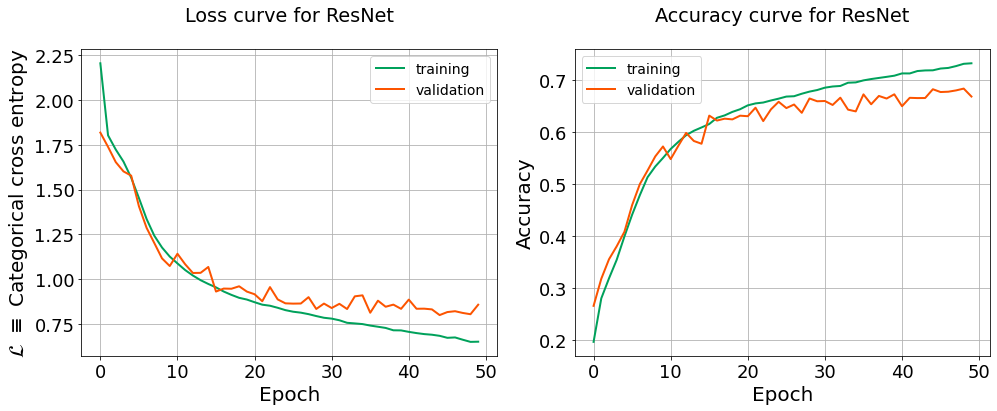

In [29]:
# plots the history
fig, ax = plt.subplots(1,2, figsize=(14,6))
labels = ['training', 'validation']
loss_Accuracy = ['loss', 'val_loss', 'categorical_accuracy', 'val_categorical_accuracy']

model_history = model_history.history
dat.plotLoss(ax[0], model_history, loss_Accuracy, model_name, labels)
dat.plotAccuracy(ax[1], model_history, loss_Accuracy, model_name, labels)
 
fig.savefig(save_image_dir+'/LandA_inter%s_epochs_%d.png'%(model_name, max_epochs))    
fig.tight_layout()

### 6. Displaying the classification report, confusion matrix

In [30]:
y_predict = np.argmax(predictions, axis=1)
y_test = np.argmax(testy, axis=1)

print('Test set classification report:\n')
print(classification_report(y_test, y_predict, target_names=output_class_names))

Test set classification report:

              precision    recall  f1-score   support

           2       0.90      0.90      0.90       983
           4       0.88      0.84      0.86      1026
          10       0.91      0.67      0.77      1010
          15       0.81      0.67      0.73       987
          20       0.68      0.75      0.71       991
          30       0.66      0.62      0.64      1005
          40       0.49      0.70      0.58      1008
          60       0.58      0.63      0.60      1036
          80       0.40      0.44      0.42       971
         100       0.50      0.41      0.45       983

    accuracy                           0.66     10000
   macro avg       0.68      0.66      0.67     10000
weighted avg       0.68      0.66      0.67     10000



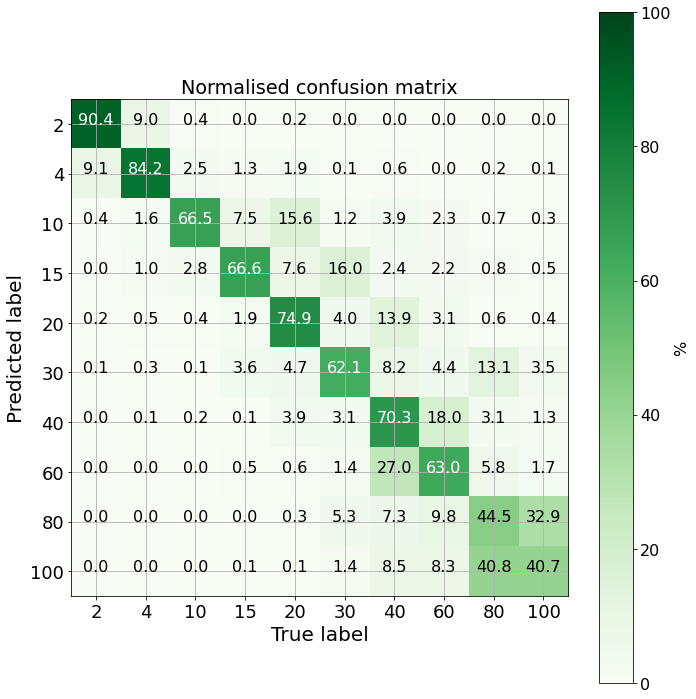

In [31]:
# need this to avoid callback errors
from sklearn.metrics import confusion_matrix
importlib.reload(dat)

# generate confusion matrix
cfm = confusion_matrix(y_test, y_predict)  

# row normalisation of confusion matrix
cfm_probability = cfm.astype('float')/cfm.sum(axis=1)[:, np.newaxis]  
# confusion probability matrix
cfm_probability = cfm_probability * 100.0  

fig, ax = plt.subplots(1,1, figsize=(10,10))
dat.plotConfusionMatrix(ax, cfm_probability, output_class_names, 2)

# save figure
fig.savefig(save_image_dir+'/cfm_%s_epochs_%d_noInter.png'%(model_name, max_epochs))    
fig.tight_layout()